In [1]:
from sklearn.model_selection import train_test_split 
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np

digits = load_digits()
X, Y = digits.data, digits.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state = 42)

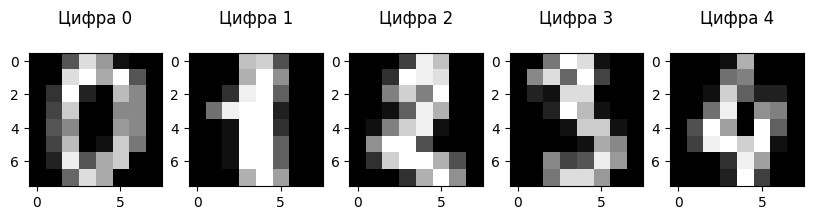

In [2]:
plt.figure(figsize=(10,4))
for index, (image, label) in enumerate(zip(X[0:5], Y[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Цифра %i\n' % label, fontsize = 12)

In [3]:
X_train.shape

(1437, 64)

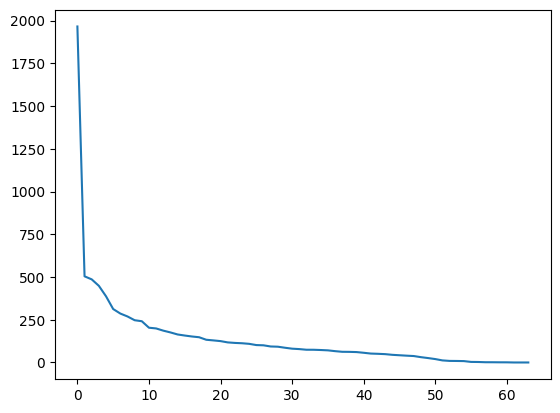

In [4]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=64)
X_new = svd.fit_transform(X_train)

plt.plot(svd.singular_values_)

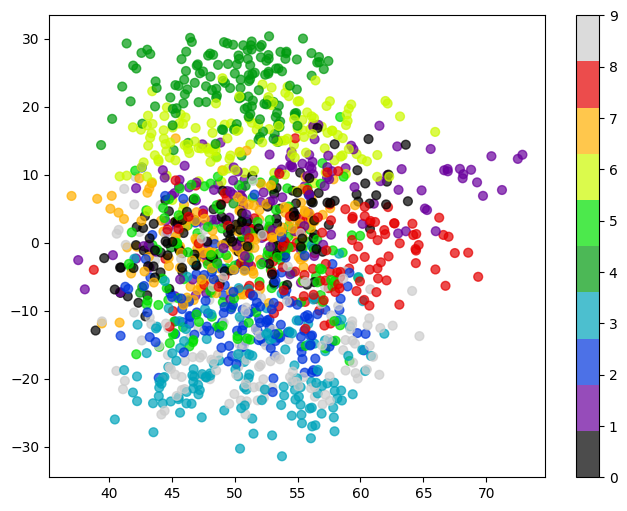

In [5]:
# визуализируем обучающий датасет 
plt.figure(figsize=(8,6))
plt.scatter(X_new[:, 0], X_new[:, 1], c=Y_train, 
            alpha=0.7, s=40,
            cmap=plt.get_cmap('nipy_spectral', 10))
plt.colorbar()

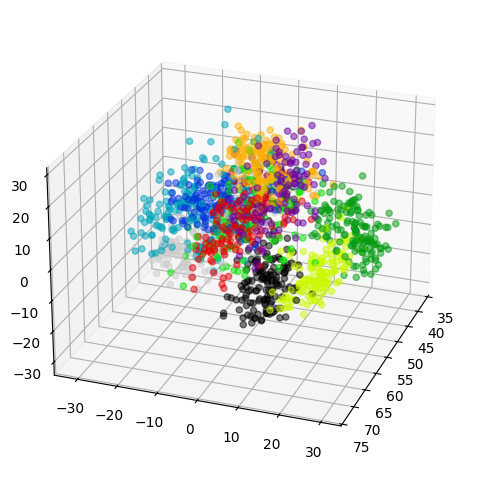

In [6]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_new[:, 0], X_new[:, 1], X_new[:, 2], c = Y_train, 
           alpha = 0.5, cmap=plt.get_cmap('nipy_spectral', 10))
ax.view_init(25,20)
plt.show()

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [21]:
# Создаем классификатор kNN с заданным числом соседей (k=5)
k = 5  # число соседей в kNN

### 1. Вычислим исходное качество (score1) без уменьшения размерности
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, Y_train)
score1 = knn.score(X_test, Y_test)
print(f"Точность классификатора на исходное качество (score1): {score1:.4f}")

Точность классификатора на исходное качество (score1): 0.9833


In [24]:
### 2. Применяем SVD к X_train (центрируем данные)
X_train_centered = X_train - np.mean(X_train, axis=0)  # важно для SVD
U, s, Vt = np.linalg.svd(X_train_centered, full_matrices=False)

### 3. Перебираем разные d и ищем минимальное, где падение <1%
max_features = X_train.shape[1]
min_d = max_features  # начальное значение

for d in range(1, max_features + 1):
    # Берем первые d компонент
    U_d = U[:, :d]
    S_d = np.diag(s[:d])
    Vt_d = Vt[:d, :]
    
    # Преобразуем X_train и X_test в новое пространство
    X_train_svd = U_d @ S_d  # эквивалентно X_train_centered @ Vt_d.T
    X_test_centered = X_test - np.mean(X_train, axis=0)  # центрируем как обучающую
    X_test_svd = X_test_centered @ Vt_d.T
    
    # Обучаем kNN
    knn_svd = KNeighborsClassifier(n_neighbors=k)
    knn_svd.fit(X_train_svd, Y_train)
    score2 = knn_svd.score(X_test_svd, Y_test)
    
    # Проверяем падение качества
    relative_drop = (score1 - score2) / score1
    print(f"d = {d}, score2 = {score2:.4f}, падение = {relative_drop * 100:.2f}%")
    
    if relative_drop < 0.01:
        min_d = d
        break  # останавливаемся, если падение <1%

print(f"\nМинимальная d с падением <1%: {min_d}")

d = 1, score2 = 0.3639, падение = 62.99%
d = 2, score2 = 0.6111, падение = 37.85%
d = 3, score2 = 0.7750, падение = 21.19%
d = 4, score2 = 0.8417, падение = 14.41%
d = 5, score2 = 0.9278, падение = 5.65%
d = 6, score2 = 0.9444, падение = 3.95%
d = 7, score2 = 0.9556, падение = 2.82%
d = 8, score2 = 0.9556, падение = 2.82%
d = 9, score2 = 0.9667, падение = 1.69%
d = 10, score2 = 0.9583, падение = 2.54%
d = 11, score2 = 0.9694, падение = 1.41%
d = 12, score2 = 0.9722, падение = 1.13%
d = 13, score2 = 0.9694, падение = 1.41%
d = 14, score2 = 0.9778, падение = 0.56%

Минимальная d с падением <1%: 14
